<a href="https://colab.research.google.com/github/HannaRF/Deep-K-Means/blob/main/Deep%20K-Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Programming Assignment 5: Deep k-Means: Jointly clustering with k-Means and learning representations**

This exercise implements the [DKM](https://arxiv.org/pdf/1806.10069.pdf) approach. The method study the problem of jointly clustering and learning representations.

**Assumption**: Learning representations that are both faithful to the data to be clustered and adapted to the clustering algorithm can lead to better clustering performance, all the more so that the two tasks are performed jointly.

## Deep k-Means variants

In the experiments, we considered two variants of this approach: the **Annealing** and the **Pretrained**.

**DKMa** implements an **annealing** strategy for $\alpha$ and does not rely on pretraining. In the scheme, the evolution of the $\alpha$ is given by the following recursive sequence:

$\alpha_{n+1}= 2^{1/log(n)^2} ×\alpha_n$ with $m_\alpha = \alpha_1= 0.1$

The rationale behind the choice of this scheme is that we want alpha to spend more iterations on smaller values and less on larger values while preserving a gentle slope.

**DKMp** variant is initialized by first pretraining an auto-encoder and then applying the jointly clustering approach with a constant $\alpha$ such that $m_\alpha = M_\alpha= 1000$. Such a high $\alpha$ is equivalent to having hard cluster assignments.

###**Code**

In [ ]:
import tensorflow as tf
from tensorflow.compat.v1 import keras
import argparse
import seaborn as sns
import numpy as np
from tensorflow.compat.v1.keras.layers import Dense
from tensorflow.compat.v1.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.compat.v1.keras.optimizers import Adam, SGD
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Input
from sklearn.cluster import KMeans
!pip install visualkeras
import visualkeras
from tensorflow.compat.v1.keras.layers import Layer
from tensorflow.keras.layers import InputSpec
from tensorflow.compat.v1.keras import backend as K
import sklearn.metrics as metrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 8.6 MB/s eta 0:00:00


###**Load dataset**

Image dataset consist of MNIST (70,000 images, 28×28 pixels, 10 classes) containing hand-written digit images.

11490434/11490434 [==============================] - 0s 0us/step
MNIST samples (70000, 784)


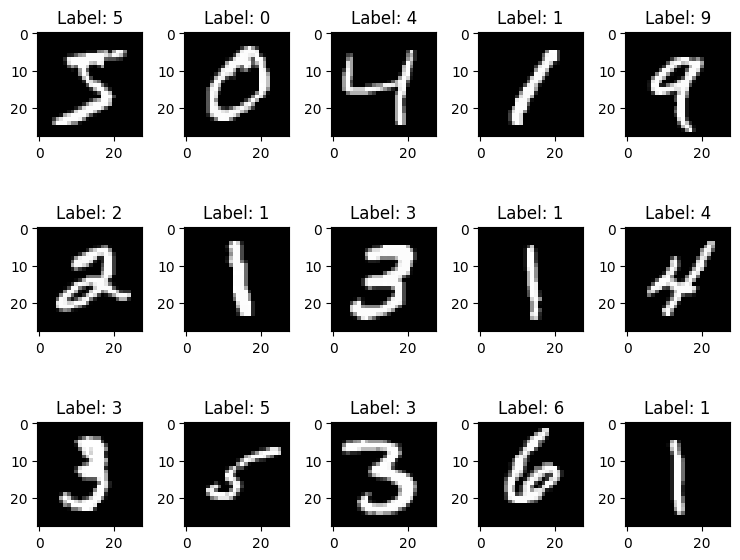

In [ ]:
def load_mnist():
    # the data, shuffled and split between train and test sets
    from keras.datasets import mnist

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x = np.concatenate((x_train, x_test))
    y = np.concatenate((y_train, y_test))
    # reshape x to (70000, 28*28)
    x = x.reshape((x.shape[0], -1))
    x = np.divide(x, 255.)
    print('MNIST samples', x.shape)

    num = 15
    images = x_train[:num]
    labels = y_train[:num]
    num_row = 3
    num_col = 5
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(images[i], cmap='gray')
        ax.set_title('Label: {}'.format(labels[i]))
    plt.tight_layout()
    plt.show()

    return x, y

x, y = load_mnist()

###**Funções Gerais**

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, labels = None, batch_size = 64, dim = 28, n_classes=10,
                 samp_per_epoch = None, shuffle=False, flag_AE = False):
        '''
        Parameters
        ----------
        data : image stack with shape (row, col, channels*seq)
        labels : labels stack with shape (row, col, seq)
        coords : x,y coordinate for each pixel of interest
        idx_coord : index of coordinates, shape (len(coords),2)
        channels : channels of imput data for each seq. The default is 14.
        patch_size : patch size. The default is 15.
        batch_size : The default is 32.
        dim : input dimension for the CNN model. The default is (15,15,14).
        n_classes : number of classes. The default is 4.
        samp_per_epoch : (optional) # of samples for each epoch. The default is None.
        shuffle : (optional) shuffle after each epoch. The default is False.
        use_augm : (optional) data augmenattion. The default is False.

        Returns
        -------
            Datagenerator

        '''
        self.data = data
        self.label = labels
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_classes = n_classes
        self.samp_per_epoch = samp_per_epoch
        self.flag_AE = flag_AE
        self.list_IDs = np.arange(len(self.data))

        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.samp_per_epoch:
            # train over #samp_per_epoch random samples at each epoch
            return int(np.ceil(self.samp_per_epoch / self.batch_size))
        else:
            # use all avaliable samples at each epoch
            return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        if (index+1)*self.batch_size > len(self.indexes):
            indexes = self.indexes[index*self.batch_size:]
        else:
            indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        idx_tmp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, Y = self.__data_generation(idx_tmp)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes and list coords after each epoch'
        if self.samp_per_epoch:
            self.indexes = np.arange(self.samp_per_epoch)
        else:
            self.indexes = np.arange(len(self.list_IDs))

        if self.shuffle == True:
            # shuffle indexes we use to iterate on
            np.random.shuffle(self.indexes)

    def __data_generation(self, idx_tmp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim)
        # Initialization
        X = np.empty((len(idx_tmp), self.dim*self.dim))

        X = self.data[idx_tmp]

        if self.flag_AE:
            return X, X

        return X, [X, np.ones((len(idx_tmp)))]


def make_autoencoder(dims, act='relu'):
        """
        Fully connected auto-encoder model, symmetric.
        Arguments:
            dims: list of number of units in each layer d-500-500-2000-K,
                  where d is the original data space dimension and K is the number
                  of clusters to obtain.
                  The decoder is symmetric with encoder.
        return:
            Model of autoencoder
        """
        n_stacks = len(dims) - 1
        # input
        x = Input(shape=(dims[0],), name='input')
        h = x

        # internal layers in encoder
        for i in range(n_stacks-1):
            h = Dense(dims[i + 1], activation=act, name='encoder_%d' % i)(h)

        # hidden layer
        encoder_layer = Dense(dims[-1], name='encoder_%d' % (n_stacks - 1))(h)  # hidden layer, features are extracted from here

        # internal layers in decoder
        for i in range(n_stacks-1, 0, -1):
            if i == n_stacks-1:
                h = encoder_layer
            h = Dense(dims[i], activation=act, name='decoder_%d' % i)(h)

        # output
        h = Dense(dims[0], name='AE_')(h)

        encoder = Model(inputs=x, outputs=encoder_layer)
        autoencoder = Model(inputs=x, outputs=h)

        return autoencoder,encoder

# Reconstruction Loss
def g_func(x, x_):
   return tf.reduce_sum(tf.square(x - x_), axis=1)

def Loss_AE():
    """The AE network is trained by minimizing the reconstruction error,
    L(x,x^), which measures the differences between our original input and
    the consequent reconstruction. """
    def loss(y_true, y_pred):
        rec_error = g_func(y_true, y_pred)
        ae_loss = tf.reduce_mean(rec_error)
        return ae_loss
    return loss


def f_func(h, rk):
   return tf.reduce_sum(tf.square(h - rk), axis=1)

class DistanceLayer(Layer):
    """ Layer which calculates the distance from each point to all centroids"""

    def __init__(self, n_clusters, weights=None, alpha = 1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(DistanceLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        initializer = tf.keras.initializers.RandomUniform(minval=-1, maxval=1)
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer= initializer, name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        ## Compute the distance f between the embedding and each cluster representative
        list_dist = []
        for i in range(0, self.n_clusters):
            dist = f_func(inputs, self.clusters[i:i+1, :])
            list_dist.append(dist)
        self.stack_dist = tf.stack(list_dist)

        return tf.transpose(self.stack_dist)

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(DistanceLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class  Softmax_function(Layer):
    """ Layer which calculates the softmax function from the distance
    of the samples to the centroids"""

    def __init__(self, n_clusters, weights=None, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(Softmax_function, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)


    def build(self, input_shape):
        assert len(input_shape) == 2
        #input_dim = input_shape[1]
        #self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.alpha = self.add_weight(shape=(1,), initializer='glorot_uniform', name='alpha')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True


    def call(self, dists, **kwargs):

        dists = tf.transpose(dists)
        # Second, find the minimum squared distance for softmax normalization
        min_dist = tf.reduce_min(dists, axis=0)
        # Third, compute exponentials shifted with min_dist to avoid underflow (0/0) issues in softmaxes
        list_exp = []
        for i in range(self.n_clusters):
            exp = tf.exp(-self.alpha * (dists[i] - min_dist))
            list_exp.append(exp)
        stack_exp = tf.stack(list_exp)
        sum_exponentials = tf.reduce_sum(stack_exp, axis=0)
        # print(sum_exponentials.get_shape().as_list())
        #Compute softmaxes and the embedding/representative distances weighted by softmax
        list_softmax = []
        list_weighted_dist = []
        for j in range(self.n_clusters):
            softmax = stack_exp[j] / sum_exponentials
            weighted_dist = dists[j] * softmax
            list_softmax.append(softmax)
            list_weighted_dist.append(weighted_dist)
        stack_weighted_dist = tf.stack(list_weighted_dist)

        stack_weighted_dist = tf.transpose(stack_weighted_dist)
        return stack_weighted_dist

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0],

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(Softmax_function, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def Loss_Clustering(lambda_):

    def loss(y_true, y_pred):
        return tf.reduce_mean(tf.reduce_sum(tf.transpose(y_pred), axis=0)) * lambda_

    return loss

###**Funções de Treinamento**

In [ ]:
def pretrain_and_kmeans(x, autoencoder, encoder, n_clusters, optimizer, num_epochs_AE=10):
    # Step 1: Pretrain the autoencoder
    autoencoder.compile(optimizer=optimizer, loss=Loss_AE())

    training_generator = DataGenerator(x, labels=None, batch_size=256, dim=dims[0], n_classes=10,
                                       samp_per_epoch=None, shuffle=True, flag_AE=True)

    # Train model on dataset
    history = autoencoder.fit_generator(generator=training_generator, epochs=num_epochs_AE)

    # Step 2: Initialize cluster centers using k-means
    print('Initializing cluster centers with k-means')
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++")

    AE_generator = DataGenerator(x, labels=None, batch_size=256, dim=dims[0], n_classes=10,
                                 samp_per_epoch=None, shuffle=False, flag_AE=True)

    print('Extract Features')
    extract_features = encoder.predict_generator(AE_generator, verbose=1)

    y_pred = kmeans.fit_predict(extract_features)

    return y_pred, kmeans

def create_deep_clustering_model(autoencoder, n_stacks, n_clusters):
    hidden = autoencoder.get_layer(name='encoder_%d' % (n_stacks - 1)).output
    encoder = Model(inputs=autoencoder.input, outputs=hidden)

    distance_layer = DistanceLayer(n_clusters=n_clusters, name='distance')(hidden)
    softmax_function = Softmax_function(n_clusters, trainable=False, name='clustering')(distance_layer)

    Deep_km = Model(inputs=encoder.input, outputs=[autoencoder.output, softmax_function])
    model_see = Model(inputs=encoder.input, outputs=softmax_function)

    return Deep_km, model_see,distance_layer

def train_deep_clustering_model(Deep_km, alphas, x, optimizer, kmeans=None, num_epochs_per_alpha=1):
    if Pre_train and kmeans is not None:
        Deep_km.get_layer(name='distance').set_weights([kmeans.cluster_centers_])

    deep_kmeans_gen = DataGenerator(x, labels=None, batch_size=256, dim=dims[0], n_classes=10, samp_per_epoch=None, shuffle=True)

    for k in range(len(alphas)):
        print("Training step: alpha[{}]: {}".format(k, alphas[k]))

        Deep_km.get_layer(name='clustering').set_weights([alphas[k:k+1]])

        print(Deep_km.get_layer(name='clustering').get_weights()[0].reshape((-1))[0])

        history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)

    Deep_km_predictor = Model(inputs=Deep_km.input, outputs=Deep_km.get_layer(name='distance').output)

    AE_generator = DataGenerator(x, None, batch_size=256, dim=dims[0], n_classes=10, shuffle=False)

    extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)

    y_pred = np.argmin(extract_feat, axis=1)

    return y_pred

## Parâmetros e Treinamento

In [ ]:
dims = [x.shape[-1], 500, 500, 2000, 10]
n_stacks = len(dims) - 1
autoencoder,encoder = make_autoencoder(dims)

Pre-train Scheme Done!


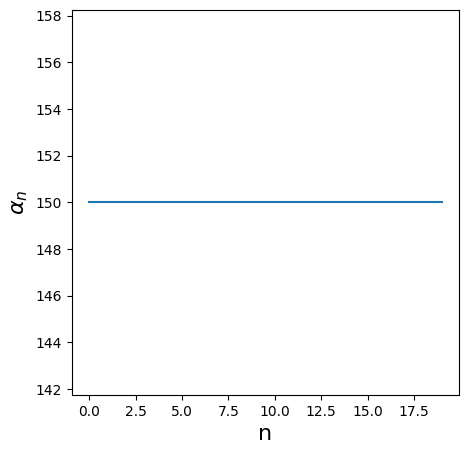

In [ ]:
optimizer= Adam(learning_rate=1e-3)
n_clusters = 20
lambda_ = 1
num_epochs_AE = 50

#################### CODE HERE ################################

Pre_train = True
Annealing = False

#Alpha Parameter
if Annealing and not Pre_train:

    constant_value = 1  # Used to modify the range of the alpha scheme
    max_n = 40  # Number of alpha values to consider
    alphas = np.zeros(max_n, dtype=float)
    alphas[0] = 0.5
    for i in range(1, max_n):
        alphas[i] = (2 ** (1 / (np.log(i + 1)) ** 2)) * alphas[i - 1]
    alphas = alphas / constant_value
    print("Annealing Scheme Done!")

elif not Annealing and Pre_train:

    constant_value = 1  # Used to modify the range of the alpha scheme
    max_n = 20  # Number of alpha values to consider
    alpha = 150
    alphas = alpha*np.ones(max_n, dtype=float) # alpha is constant
    alphas = alphas / constant_value
    print("Pre-train Scheme Done!")
else:

    parser.error("Run with either annealing or pretraining, but not both for DKM.")
    exit()
###############################################################
plt.figure(figsize=(5,5))
plt.plot(np.arange(max_n),alphas)
plt.xlabel('n',fontsize = 16); plt.ylabel(r'$\alpha_n$',fontsize = 16);

In [ ]:

Deep_km, model_see,distance_layer = create_deep_clustering_model(autoencoder, n_stacks, n_clusters)
model_see.summary()
Deep_km.compile(optimizer=optimizer, loss=[Loss_AE(), Loss_Clustering(lambda_)])

if Pre_train:
  y_pred, kmeans = pretrain_and_kmeans(x, autoencoder, encoder, n_clusters, optimizer, num_epochs_AE)
  y_pred = train_deep_clustering_model(Deep_km, alphas, x, optimizer, kmeans)
else:
  y_pred = train_deep_clustering_model(Deep_km, alphas, x, optimizer)

Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 20)                200       
                                                                 
 clustering (Softmax_functi  (None, 20)                1  

<ipython-input-5-ce2c7326a071>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(generator=training_generator, epochs=num_epochs_AE)


274/274 [==============================] - 2s 6ms/step - loss: 6.3210
Epoch 2/50
274/274 [==============================] - 2s 7ms/step - loss: 6.2414
Epoch 3/50
274/274 [==============================] - 2s 6ms/step - loss: 6.2561
Epoch 4/50
274/274 [==============================] - 1s 5ms/step - loss: 6.2641
Epoch 5/50
274/274 [==============================] - 2s 6ms/step - loss: 6.2611
Epoch 6/50
274/274 [==============================] - 2s 5ms/step - loss: 6.2811
Epoch 7/50
274/274 [==============================] - 1s 5ms/step - loss: 6.2581
Epoch 8/50
274/274 [==============================] - 2s 7ms/step - loss: 6.2675
Epoch 9/50
274/274 [==============================] - 2s 6ms/step - loss: 6.2584
Epoch 10/50
274/274 [==============================] - 2s 6ms/step - loss: 6.2677
Epoch 11/50
274/274 [==============================] - 2s 5ms/step - loss: 6.2590
Epoch 12/50
274/274 [==============================] - 2s 5ms/step - loss: 6.2593
Epoch 13/50
274/274 [===============

<ipython-input-5-ce2c7326a071>:19: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_features = encoder.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training step: alpha[0]: 150.0
150.0


<ipython-input-5-ce2c7326a071>:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)


274/274 [==============================] - 9s 14ms/step - loss: 6.2836 - AE__loss: 6.2136 - clustering_loss: 0.0700
Training step: alpha[1]: 150.0
150.0
274/274 [==============================] - 4s 14ms/step - loss: 6.2806 - AE__loss: 6.2125 - clustering_loss: 0.0681
Training step: alpha[2]: 150.0
150.0
274/274 [==============================] - 4s 14ms/step - loss: 6.3021 - AE__loss: 6.2355 - clustering_loss: 0.0666
Training step: alpha[3]: 150.0
150.0
274/274 [==============================] - 5s 17ms/step - loss: 6.2854 - AE__loss: 6.2198 - clustering_loss: 0.0656
Training step: alpha[4]: 150.0
150.0
274/274 [==============================] - 4s 13ms/step - loss: 6.2800 - AE__loss: 6.2153 - clustering_loss: 0.0646
Training step: alpha[5]: 150.0
150.0
274/274 [==============================] - 4s 13ms/step - loss: 6.2515 - AE__loss: 6.1877 - clustering_loss: 0.0639
Training step: alpha[6]: 150.0
150.0
274/274 [==============================] - 4s 16ms/step - loss: 6.2710 - AE__loss:

<ipython-input-5-ce2c7326a071>:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step



## **Evaluation Metrics**

In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment as linear_assignment

def assignment_cluster(y_true, y_pred):

    w = np.zeros((y_pred.max() + 1, y_true.max() + 1), dtype=np.int64)

    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    ind = linear_assignment(w.max() - w)

    aux = np.zeros_like(y_pred)
    for i in range(len(ind[0])):
        aux[y_pred == ind[0][i]] = ind[1][i]
    y_pred_map = aux

    return y_pred_map

print(y_pred)
y_pred_map = assignment_cluster(y, y_pred)
print(y_pred_map)

[ 4  8  5 ...  9 14 12]
[5 0 0 ... 4 0 6]


In [ ]:
def calculate_evaluation_metrics(y_true, y_pred):
    # Calcular as métricas
    acc = np.round(metrics.accuracy_score(y_true, y_pred), 5)
    nmi = np.round(metrics.normalized_mutual_info_score(y_true, y_pred), 5)
    f1score = 100 * metrics.f1_score(y_true, y_pred, average=None)

    # Retornar as métricas
    return acc, nmi, f1score

def plot_f1_score_per_class(f1score):
    # Configuração para o gráfico de barras
    classes = np.arange(len(f1score))  # as classes são numeradas de 0 a len(f1score) - 1
    width = 0.35

    # Criar o gráfico de barras
    fig, ax = plt.subplots()
    rects1 = ax.bar(classes, f1score, width, label='Digits')

    # Adicionar rótulos e título ao gráfico
    ax.set_ylabel('Scores', fontsize=15)
    ax.set_xlabel('Digits', fontsize=15)
    ax.set_title('F1 score per class', fontsize=15)
    ax.set_xticks(classes)
    ax.legend()

    # Ajustar o layout e exibir o gráfico
    fig.tight_layout()
    plt.show()



def plot_confusion_heatmap(y_true, y_pred, classes=None, figsize=(6, 6)):
    """
    Plota um heatmap da matriz de confusão normalizada.

    Parâmetros:
    - y_true: Rótulos verdadeiros.
    - y_pred: Rótulos previstos.
    - classes: Lista de classes (opcional).
    - figsize: Tamanho da figura (largura, altura).
    """
    if classes is None:
        classes = np.unique(y_true)

    cm = metrics.confusion_matrix(y_true, y_pred, labels=classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.round(cm, decimals=2)

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, cbar=False, cmap="YlGnBu", linewidths=.5, linecolor='black')

    plt.title('Accuracy: ' + str(np.round(metrics.accuracy_score(y_true, y_pred), decimals=2)), fontsize=16)
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)
    plt.show()


Acc = 0.55969, NMI = 0.48995


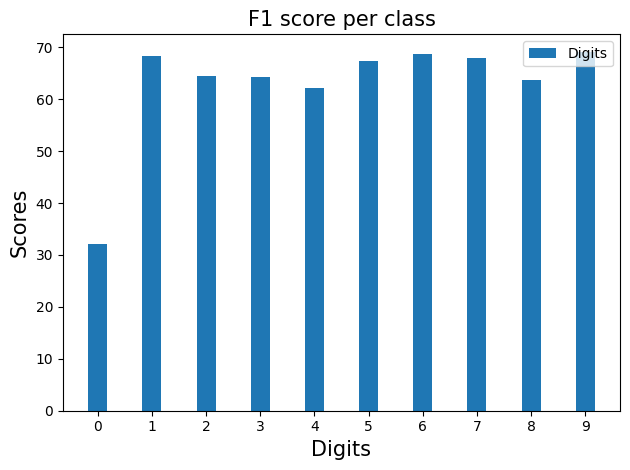

In [ ]:
acc, nmi, f1score = calculate_evaluation_metrics(y, y_pred_map)

print('Acc = %.5f, NMI = %.5f' % (acc, nmi))

plot_f1_score_per_class(f1score)

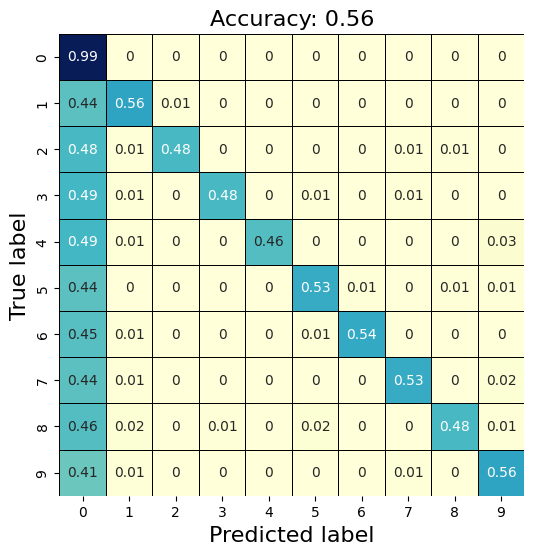

In [ ]:
plot_confusion_heatmap(y, y_pred_map)


###**Task 1**: Train the Deep k Means with different modes and alpha values, and discuss the impact of the parameters on the cluster results. Discuss also the impact on different classes.

| Configuration       | **$\alpha$**-Pretrained    | **$\alpha$**-Annealing  |**Accuracy**  |
| :-----------:        | :-----------: | :---------: |:---------: |
| 1                    |         | $\alpha_0$=0.01     ||
| 2                    |         |  $\alpha_0$=0.1      ||
| 3                    |        |  $\alpha_0$=0.5       ||
| 4                    |        | $\alpha_0$=1       ||
| 5                    | $\alpha_n$=3        |       ||
| 6                    |   $\alpha_n$= 30      |      ||
| 7                    |  $\alpha_n$= 150        |      ||
| 8                    |   $\alpha_n$=   300     |      ||

###**Task 2**: Vary the number of clusters for the best result configuration: 2, 5, 10, 20. Comment on how the clusters group the classes and show examples of images and/or the original classes distribution in each cluster to justify the discussion.